### Objective:

In this notebook,We have explored how people are travelling from different stops in Adelaide Metropolitan area and managing the buses on each route according to the no of passenger commuting through the buses.

In [ ]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime
import os
from math import sqrt
import warnings

## For Multiple Output in single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('../input/unisys/ptsboardingsummary/20140711.CSV')
data.shape
data.head(10)

(10857234, 6)

,TripID,RouteID,StopID,StopName,WeekBeginning,NumberOfBoardings
0,23631,100,14156,181 Cross Rd,2013-06-30 00:00:00,1
1,23631,100,14144,177 Cross Rd,2013-06-30 00:00:00,1
2,23632,100,14132,175 Cross Rd,2013-06-30 00:00:00,1
3,23633,100,12266,Zone A Arndale Interchange,2013-06-30 00:00:00,2
4,23633,100,14147,178 Cross Rd,2013-06-30 00:00:00,1
5,23634,100,13907,9A Marion Rd,2013-06-30 00:00:00,1
6,23634,100,14132,175 Cross Rd,2013-06-30 00:00:00,1
7,23634,100,13335,9A Holbrooks Rd,2013-06-30 00:00:00,1
8,23634,100,13875,9 Marion Rd,2013-06-30 00:00:00,1
9,23634,100,13045,206 Holbrooks Rd,2013-06-30 00:00:00,1


In [ ]:
out_geo = pd.read_csv('../input/outgeo/output_geo.csv')
out_geo.shape
out_geo.head()

(4165, 10)

,accuracy,formatted_address,google_place_id,input_string,latitude,longitude,number_of_results,postcode,status,type
0,ROOFTOP,"181 Cross Rd, Westbourne Park SA 5041, Australia",ChIJKT7I9rbPsGoRVHMHkIy-Oyk,181 Cross Rd,-34.966656,138.592148,1,5041,OK,street_address
1,ROOFTOP,"177 Cross Rd, Westbourne Park SA 5041, Australia",ChIJ-VFZ87bPsGoRyfVgC5qbPpE,177 Cross Rd,-34.966607,138.592301,1,5041,OK,street_address
2,ROOFTOP,"175 Cross Rd, Westbourne Park SA 5041, Australia",ChIJIztlirbPsGoR38KRk76kPFI,175 Cross Rd,-34.966758,138.592715,1,5041,OK,street_address
3,GEOMETRIC_CENTER,"Zone A Arndale Interchange - South side, Kilke...",ChIJn0C1hCPGsGoRIWvCdhF1RIg,Zone A Arndale Interchange,-34.875160,138.551628,1,5009,OK,"bus_station,establishment,point_of_interest,tr..."
4,ROOFTOP,"178 Cross Rd, Malvern SA 5061, Australia",ChIJycNiylvOsGoRdhfq9GKnpq0,178 Cross Rd,-34.964960,138.611477,1,5061,OK,street_address


## External Features <a id="4"></a>

In [ ]:
#DistanceFromCentre: Distance measure from the city centre
#For Calculating Distance between centre with other bus stops by using Longitude and Latitude
#we have used the Haversine formula

from math import sin, cos, sqrt, atan2, radians
def calc_dist(lat1,lon1):
    ## approximate radius of earth in km
    R = 6373.0
    dlon = radians(138.604801) - radians(lon1)
    dlat = radians(-34.921247) - radians(lat1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(-34.921247)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [ ]:
out_geo['dist_from_centre'] = out_geo[['latitude','longitude']].apply(lambda x: calc_dist(*x), axis=1)

In [ ]:
out_geo.head()

,accuracy,formatted_address,google_place_id,input_string,latitude,longitude,number_of_results,postcode,status,type,dist_from_centre
0,ROOFTOP,"181 Cross Rd, Westbourne Park SA 5041, Australia",ChIJKT7I9rbPsGoRVHMHkIy-Oyk,181 Cross Rd,-34.966656,138.592148,1,5041,OK,street_address,5.180961
1,ROOFTOP,"177 Cross Rd, Westbourne Park SA 5041, Australia",ChIJ-VFZ87bPsGoRyfVgC5qbPpE,177 Cross Rd,-34.966607,138.592301,1,5041,OK,street_address,5.172525
2,ROOFTOP,"175 Cross Rd, Westbourne Park SA 5041, Australia",ChIJIztlirbPsGoR38KRk76kPFI,175 Cross Rd,-34.966758,138.592715,1,5041,OK,street_address,5.180709
3,GEOMETRIC_CENTER,"Zone A Arndale Interchange - South side, Kilke...",ChIJn0C1hCPGsGoRIWvCdhF1RIg,Zone A Arndale Interchange,-34.875160,138.551628,1,5009,OK,"bus_station,establishment,point_of_interest,tr...",7.057549
4,ROOFTOP,"178 Cross Rd, Malvern SA 5061, Australia",ChIJycNiylvOsGoRdhfq9GKnpq0,178 Cross Rd,-34.964960,138.611477,1,5061,OK,street_address,4.900099


In [ ]:
#exp_data = out_geo.head(10)
##Fill the missing values with mode
out_geo['type'].fillna('street_address',inplace=True)
out_geo['type'] = out_geo['type'].apply(lambda x: str(x).split(',')[-1])

In [ ]:
out_geo['type'].unique()

array(['street_address', 'transit_station', 'premise', 'political',
       'school', 'route', 'intersection', 'point_of_interest',
       'subpremise', 'real_estate_agency', 'university', 'travel_agency',
       'restaurant', 'supermarket', 'store', 'post_office'], dtype=object)

In [ ]:
data['WeekBeginning'] = pd.to_datetime(data['WeekBeginning']).dt.date
data['WeekBeginning'][1]

datetime.date(2013, 6, 30)

## Data Aggregation <a id="5"></a>

In [ ]:
#Combine the Geolocation and main input file to get final Output File.
data= pd.merge(data,out_geo,how='left',left_on = 'StopName',right_on = 'input_string')
data.head(5)
data.shape

,TripID,RouteID,StopID,StopName,WeekBeginning,NumberOfBoardings,accuracy,formatted_address,google_place_id,input_string,latitude,longitude,number_of_results,postcode,status,type,dist_from_centre
0,23631,100,14156,181 Cross Rd,2013-06-30,1,ROOFTOP,"181 Cross Rd, Westbourne Park SA 5041, Australia",ChIJKT7I9rbPsGoRVHMHkIy-Oyk,181 Cross Rd,-34.966656,138.592148,1,5041,OK,street_address,5.180961
1,23631,100,14144,177 Cross Rd,2013-06-30,1,ROOFTOP,"177 Cross Rd, Westbourne Park SA 5041, Australia",ChIJ-VFZ87bPsGoRyfVgC5qbPpE,177 Cross Rd,-34.966607,138.592301,1,5041,OK,street_address,5.172525
2,23632,100,14132,175 Cross Rd,2013-06-30,1,ROOFTOP,"175 Cross Rd, Westbourne Park SA 5041, Australia",ChIJIztlirbPsGoR38KRk76kPFI,175 Cross Rd,-34.966758,138.592715,1,5041,OK,street_address,5.180709
3,23633,100,12266,Zone A Arndale Interchange,2013-06-30,2,GEOMETRIC_CENTER,"Zone A Arndale Interchange - South side, Kilke...",ChIJn0C1hCPGsGoRIWvCdhF1RIg,Zone A Arndale Interchange,-34.875160,138.551628,1,5009,OK,transit_station,7.057549
4,23633,100,14147,178 Cross Rd,2013-06-30,1,ROOFTOP,"178 Cross Rd, Malvern SA 5061, Australia",ChIJycNiylvOsGoRdhfq9GKnpq0,178 Cross Rd,-34.964960,138.611477,1,5061,OK,street_address,4.900099


(10857234, 17)

In [ ]:
#Columns to keep for further analysis
col = ['TripID', 'RouteID', 'StopID', 'StopName', 'WeekBeginning','NumberOfBoardings',
      'latitude', 'longitude','postcode','type','dist_from_centre']
data = data[col]

In [ ]:
##saving the final dataset
#data.to_csv('Weekly_Boarding.csv',index=False)

Aggregate the Data According to Weeks and Stop names
* **NumberOfBoardings_sum** Number of Boardings within particular week for each Bus stop
* **NumberOfBoardings_count** Number of times data is recorded within week
* **NumberOfBoardings_max** Maximum number of boarding done at single time within week

In [ ]:
grouped = data.groupby(['StopName','WeekBeginning','type'])
#grouped.head()

In [ ]:
# st_week_grp1 = pd.DataFrame(data.groupby(['StopName','WeekBeginning','type']).agg({'NumberOfBoardings': ['sum', 'count']})).reset_index()
grouped = data.groupby(['StopName','WeekBeginning','type']).agg({'NumberOfBoardings': ['sum', 'count','max']})
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]

In [ ]:
grouped.head(10)
grouped.columns

NumberOfBoardings_sum          ...            NumberOfBoardings_max
StopName    WeekBeginning type                                           ...                                 
1 Anzac Hwy 2013-06-30    street_address                   1003          ...                               51
            2013-07-07    street_address                    783          ...                               28
            2013-07-14    street_address                    843          ...                               45
            2013-07-21    street_address                    710          ...                               28
            2013-07-28    street_address                    898          ...                               41
            2013-08-04    street_address                    799          ...                               40
            2013-08-11    street_address                   1012          ...                               71
            2013-08-18    street_address                    793          ...                               41
            2013-08-25    street_address                    897          ...                               45
            2013-09-01    street_address                   1368          ...                               59

[10 rows x 3 columns]

Index(['NumberOfBoardings_sum', 'NumberOfBoardings_count',
       'NumberOfBoardings_max'],
      dtype='object')

In [ ]:
st_week_grp = pd.DataFrame(grouped).reset_index()
st_week_grp.shape
st_week_grp.head()

(207864, 6)

,StopName,WeekBeginning,type,NumberOfBoardings_sum,NumberOfBoardings_count,NumberOfBoardings_max
0,1 Anzac Hwy,2013-06-30,street_address,1003,378,51
1,1 Anzac Hwy,2013-07-07,street_address,783,360,28
2,1 Anzac Hwy,2013-07-14,street_address,843,343,45
3,1 Anzac Hwy,2013-07-21,street_address,710,356,28
4,1 Anzac Hwy,2013-07-28,street_address,898,379,41


In [ ]:
st_week_grp1 = pd.DataFrame(st_week_grp.groupby('StopName')["WeekBeginning"].count()).reset_index()
st_week_grp1.head()

,StopName,WeekBeginning
0,1 Anzac Hwy,54
1,1 Bartels Rd,54
2,1 Botanic Rd,54
3,1 Frome Rd,54
4,1 Fullarton Rd,54


In [ ]:
#Gathering only the Stop Name which having all 54 weeks of Dat
aa = list(st_week_grp1[st_week_grp1['WeekBeginning'] == 54]['StopName'])
aa[1:10]

['1 Bartels Rd',
 '1 Botanic Rd',
 '1 Frome Rd',
 '1 Fullarton Rd',
 '1 George St',
 '1 Glen Osmond Rd',
 '1 Goodwood Rd',
 '1 Henley Beach Rd',
 '1 Kensington Rd']

In [ ]:
bb = st_week_grp[st_week_grp['StopName'].isin(aa)]
bb.head()
bb.shape

type(bb)

,StopName,WeekBeginning,type,NumberOfBoardings_sum,NumberOfBoardings_count,NumberOfBoardings_max
0,1 Anzac Hwy,2013-06-30,street_address,1003,378,51
1,1 Anzac Hwy,2013-07-07,street_address,783,360,28
2,1 Anzac Hwy,2013-07-14,street_address,843,343,45
3,1 Anzac Hwy,2013-07-21,street_address,710,356,28
4,1 Anzac Hwy,2013-07-28,street_address,898,379,41


(175446, 6)

pandas.core.frame.DataFrame

In [ ]:
#removing the stoppage which are not having the data of whole 54 weeks
new_data = data[data['StopName'].isin(aa)]
new_data.shape
print("data without stopage removing: ", data.shape)
print("data, after removing stoppage not having the data of whole 54 weeks: ", new_data.shape)

(10567931, 11)

data without stopage removing:  (10857234, 11)
data, after removing stoppage not having the data of whole 54 weeks:  (10567931, 11)


In [ ]:
new_data.head(2)
filtered_data = new_data[new_data['dist_from_centre'] <= 100]
filtered_data.shape

,TripID,RouteID,StopID,StopName,WeekBeginning,NumberOfBoardings,latitude,longitude,postcode,type,dist_from_centre
0,23631,100,14156,181 Cross Rd,2013-06-30,1,-34.966656,138.592148,5041,street_address,5.180961
1,23631,100,14144,177 Cross Rd,2013-06-30,1,-34.966607,138.592301,5041,street_address,5.172525


(10341468, 11)

In [ ]:
data = filtered_data.copy()
data.shape

(10341468, 11)

In [ ]:
#No of boarding for each stopage in all weeks
#bb["StopName"].groupby(NumberOfBoardings_sum)
stopageName_with_boarding = bb.groupby(['StopName']).agg({'NumberOfBoardings_sum': ['sum']})

#stopageName_with_boarding.columns = ["_".join(x) for x in stopageName_with_boarding.columns.ravel()]
#stopageName_with_boarding.head()
stopageName_with_boarding = pd.DataFrame(stopageName_with_boarding.reset_index())

In [ ]:
#type(stopageName_with_boarding)
stopageName_with_boarding.columns = ["StopName", "Total_boarding_on_the_stopage"]
#stopageName_with_boarding.shape
stopageName_with_boarding.head()

,StopName,Total_boarding_on_the_stopage
0,1 Anzac Hwy,39429
1,1 Bartels Rd,8412
2,1 Botanic Rd,14868
3,1 Frome Rd,67458
4,1 Fullarton Rd,585


In [ ]:
## save the aggregate data
#bb.to_csv('st_week_grp.csv', index=False)

## Data Exploration <a id="6"></a>

In [ ]:
data.nunique()
#data.isnull().sum()
#data['WeekBeginning'].unique()

TripID               39211
RouteID                616
StopID                5838
StopName              3127
WeekBeginning           54
NumberOfBoardings      359
latitude              2393
longitude             2379
postcode               138
type                     8
dist_from_centre      2397
dtype: int64

## Data Visualization <a id="7"></a>

Text(0.5,1,'No of Boardings')

Text(0.5,1,'WeekBeginning')

Text(0.5,1,'most Busiest Route')

Text(0.5,1,'least Busiest Route')

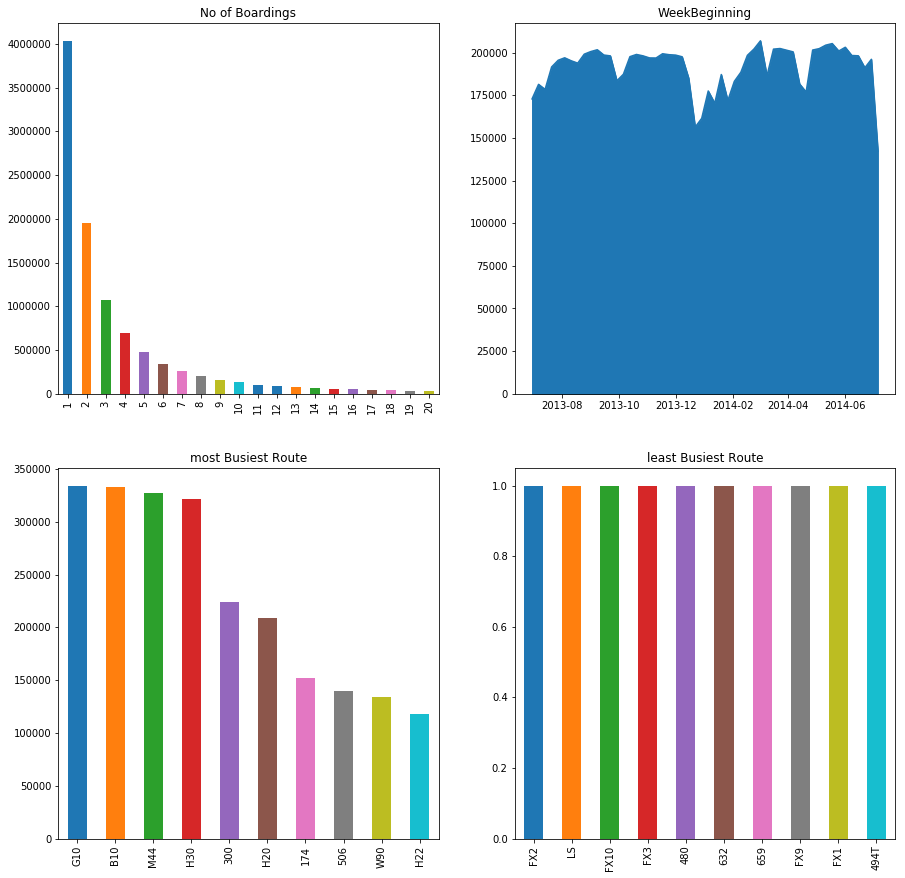

In [ ]:
##can assign the each chart to one axes at a time
fig,axrr=plt.subplots(2,2,figsize=(15,15))

ax=axrr[0][0]
ax.set_title("No of Boardings")
data['NumberOfBoardings'].value_counts().sort_index().head(20).plot.bar(ax=axrr[0][0])

ax=axrr[0][1]
ax.set_title("WeekBeginning")
data['WeekBeginning'].value_counts().plot.area(ax=axrr[0][1])

ax=axrr[1][0]
ax.set_title("most Busiest Route")
data['RouteID'].value_counts().head(10).plot.bar(ax=axrr[1][0])

ax=axrr[1][1]
ax.set_title("least Busiest Route")
data['RouteID'].value_counts().tail(10).plot.bar(ax=axrr[1][1])